# 📊 Exploratory Data Analysis (EDA)
### Germany Electricity Market (2019–2024)

**Objective:**
To quantify the structural drivers of electricity prices, specifically focusing on the relationship between **Renewable Penetration**, **Residual Load**, and **Day-Ahead Prices**.

**Key Hypotheses to Test:**
1.  **Merit Order Effect:** Do higher shares of renewable energy consistently suppress wholesale prices?
2.  **Residual Load Dependency:** Is residual load (Demand - Renewables) a strong predictor of price spikes?
3.  **Supply Structure:** How has the ratio of conventional to renewable generation evolved over the dataset timeframe?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ---------------------------------------------------------
# CONFIGURATION
# ---------------------------------------------------------
# Set professional plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Paths
DATA_PROCESSED_DIR = os.path.join("..", "data", "processed")
INPUT_FILE = os.path.join(DATA_PROCESSED_DIR, "energy_market_merged.csv")

# ---------------------------------------------------------
# LOAD DATA
# ---------------------------------------------------------
print("Loading processed data...")
df = pd.read_csv(INPUT_FILE)

# Parse dates (CSVs lose datetime format, so we restore it)
df['Start date'] = pd.to_datetime(df['Start date'])
df['End date'] = pd.to_datetime(df['End date'])

# Set Index for easier time-series plotting
df.set_index('Start date', inplace=True)

print(f"✅ Data loaded. Shape: {df.shape}")

Loading processed data...
✅ Data loaded. Shape: (2192, 34)


# 1. Feature Engineering: Generation Mix
**Objective:** Aggregate individual generation technologies into macro-categories ("Renewable" vs "Conventional") to calculate the **Renewable Share**.

* **Renewables:** Wind (On/Off), Solar, Biomass, Hydro.
* **Conventional:** Coal (Hard/Lignite), Gas, Nuclear, Pumped Storage.

In [2]:
# ---------------------------------------------------------
# DEFINE SOURCE LISTS
# ---------------------------------------------------------
# Based on SMARD column structure
renewables = [
    "Biomass [MWh] Calculated resolutions",
    "Hydropower [MWh] Calculated resolutions",
    "Wind offshore [MWh] Calculated resolutions",
    "Wind onshore [MWh] Calculated resolutions",
    "Photovoltaics [MWh] Calculated resolutions",
    "Other renewable [MWh] Calculated resolutions"
]

conventional = [
    "Nuclear [MWh] Calculated resolutions",
    "Lignite [MWh] Calculated resolutions",
    "Hard coal [MWh] Calculated resolutions",
    "Fossil gas [MWh] Calculated resolutions",
    "Hydro pumped storage [MWh] Calculated resolutions",
    "Other conventional [MWh] Calculated resolutions"
]

# ---------------------------------------------------------
# AGGREGATION
# ---------------------------------------------------------
# Safety check: Ensure columns exist before summing
available_renewables = [c for c in renewables if c in df.columns]
available_conventional = [c for c in conventional if c in df.columns]

# Calculate Totals
df['total_renewable_mwh'] = df[available_renewables].sum(axis=1)
df['total_conventional_mwh'] = df[available_conventional].sum(axis=1)

# Calculate Renewable Share (%)
# Formula: Renewables / (Renewables + Conventional)
df['renewable_share'] = df['total_renewable_mwh'] / (df['total_renewable_mwh'] + df['total_conventional_mwh'])

print("✅ Feature Engineering Complete: 'renewable_share' calculated.")
print(df[['total_renewable_mwh', 'total_conventional_mwh', 'renewable_share']].head())

✅ Feature Engineering Complete: 'renewable_share' calculated.
            total_renewable_mwh  total_conventional_mwh  renewable_share
Start date                                                              
2019-01-01            970822.75               291366.00         0.769158
2019-01-02            869852.00               500050.25         0.634974
2019-01-03            467494.50               865139.00         0.350805
2019-01-04            691397.00               765784.25         0.474476
2019-01-05            767271.25               615831.25         0.554746


# 2. Market Overview: Price & Renewable Evolution
**Analysis:**
Visualizing the daily average electricity price alongside the renewable generation curve.
* **Goal:** Identify macro-trends (e.g., the 2022 Energy Crisis spikes).
* **Technique:** We resample to a **Weekly Mean** to reduce noise and make the trend clearer.

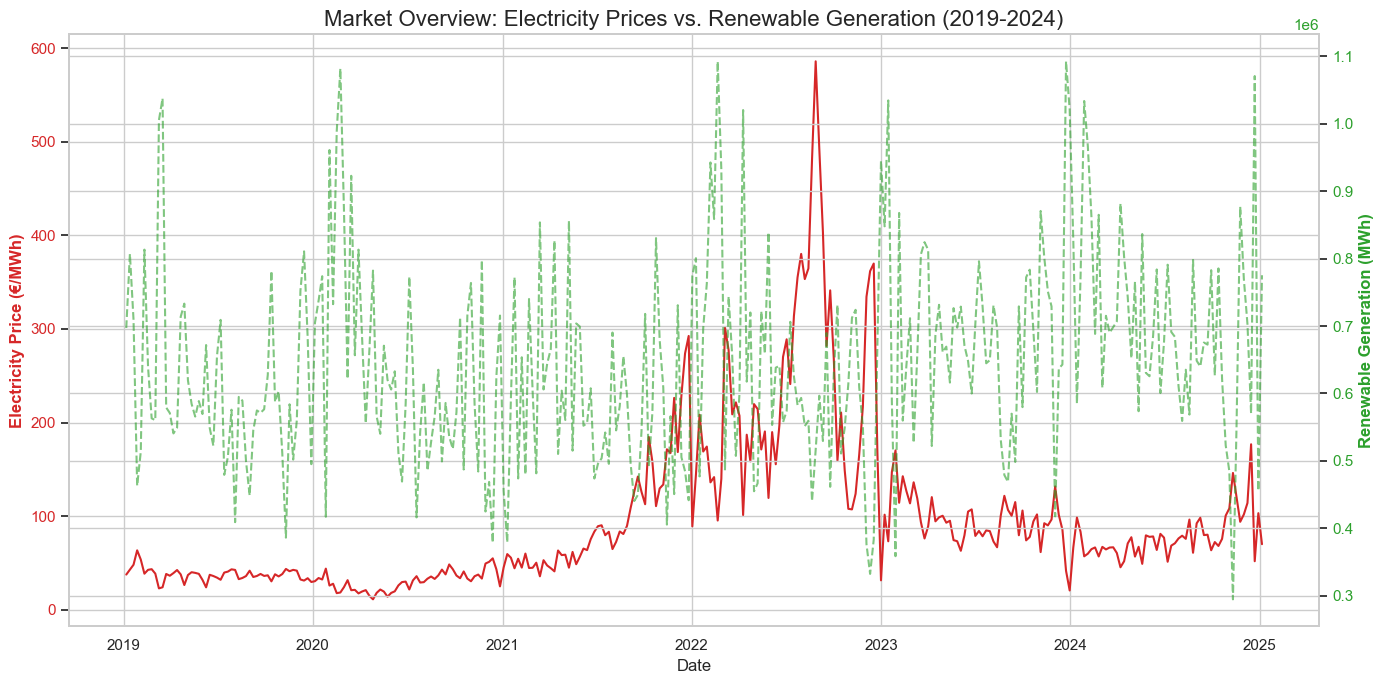

In [3]:
# Resample to Weekly Average for cleaner plots
weekly_df = df.resample('W').mean()

fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Price (Left Axis)
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Electricity Price (€/MWh)', color=color, fontweight='bold')
ax1.plot(weekly_df.index, weekly_df['price_de_lu_eur'], color=color, label='Day-Ahead Price (Weekly Avg)')
ax1.tick_params(axis='y', labelcolor=color)

# Create twin axis for Renewables (Right Axis)
ax2 = ax1.twinx()  
color = 'tab:green'
ax2.set_ylabel('Renewable Generation (MWh)', color=color, fontweight='bold')
ax2.plot(weekly_df.index, weekly_df['total_renewable_mwh'], color=color, alpha=0.6, linestyle='--', label='Renewable Gen (Weekly Avg)')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Market Overview: Electricity Prices vs. Renewable Generation (2019-2024)', fontsize=16)
fig.tight_layout()
plt.show()

# 3. The Merit Order Effect
**Hypothesis:** Higher renewable generation pushes the supply curve to the right, lowering prices.

**Visualization:**
A Scatter Plot of **Renewable Generation vs. Price**.
* **Color coding by Year** helps us see if the relationship has shifted over time (e.g., due to higher gas prices shifting the intercept).

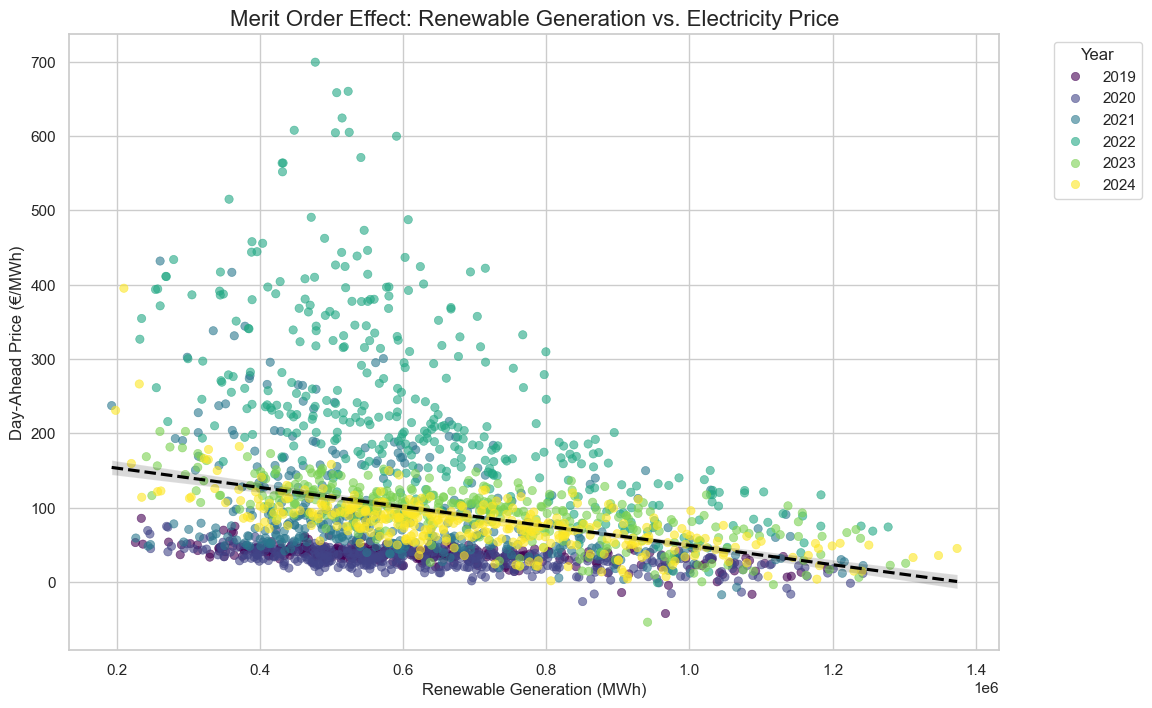

In [4]:
plt.figure(figsize=(12, 8))

# Create Scatter Plot
sns.scatterplot(
    data=df, 
    x='total_renewable_mwh', 
    y='price_de_lu_eur', 
    hue=df.index.year,   # Color by Year to see structural shifts
    palette='viridis', 
    alpha=0.6,
    edgecolor=None
)

# Add Trendline (Optional linear regression fit)
sns.regplot(
    data=df, 
    x='total_renewable_mwh', 
    y='price_de_lu_eur', 
    scatter=False, 
    color='black', 
    line_kws={'linestyle':'--'}
)

plt.title('Merit Order Effect: Renewable Generation vs. Electricity Price', fontsize=16)
plt.xlabel('Renewable Generation (MWh)')
plt.ylabel('Day-Ahead Price (€/MWh)')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 4. Residual Load Analysis
**Definition:** `Residual Load = Grid Load - Renewable Generation`
This represents the demand that *must* be met by conventional dispatchable power plants (Gas, Coal, Nuclear).

**Insight:**
We expect a positive correlation: **High Residual Load → High Prices**.

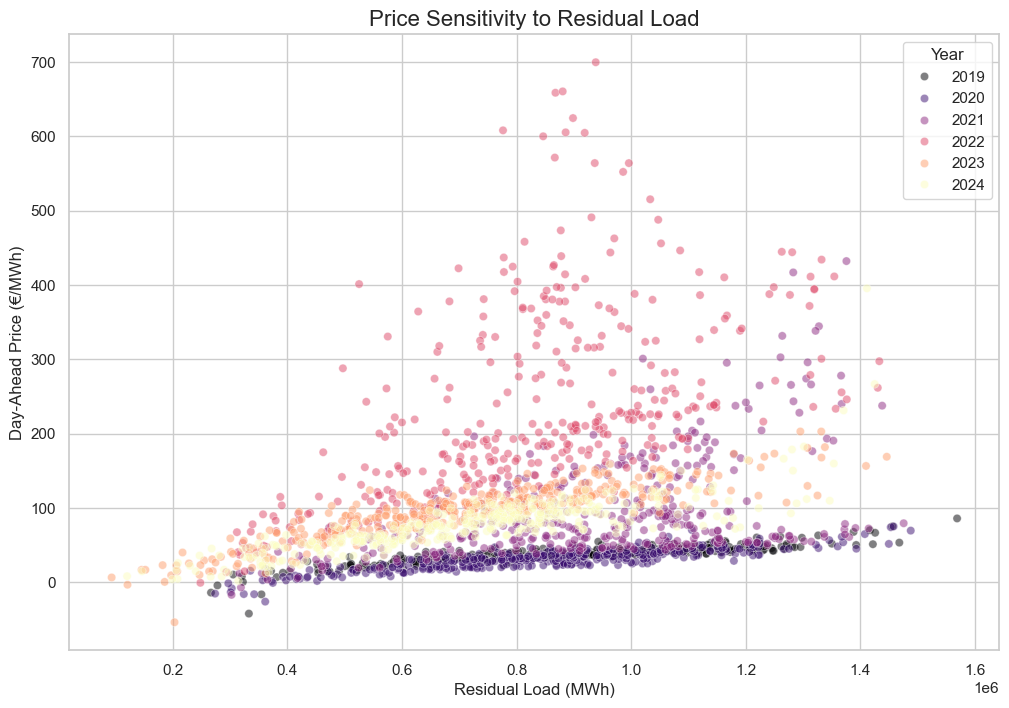

In [5]:
plt.figure(figsize=(12, 8))

# Ensure residual load is clean (handling potential outliers)
sns.scatterplot(
    data=df, 
    x='residual_load_mwh', 
    y='price_de_lu_eur', 
    hue=df.index.year, 
    palette='magma', 
    alpha=0.5
)

plt.title('Price Sensitivity to Residual Load', fontsize=16)
plt.xlabel('Residual Load (MWh)')
plt.ylabel('Day-Ahead Price (€/MWh)')
plt.legend(title='Year')
plt.show()

# 5. Statistical Correlation Matrix
**Objective:** Provide a numeric summary of relationships between key variables.

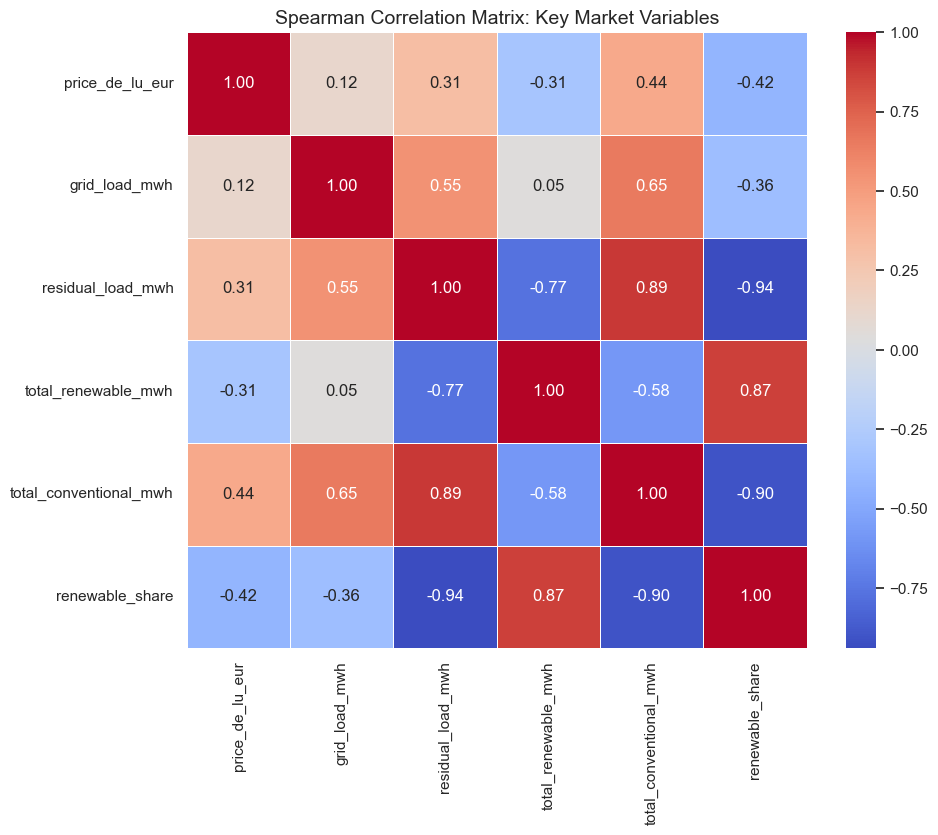

In [6]:
# Select columns for correlation
corr_cols = [
    'price_de_lu_eur', 
    'grid_load_mwh', 
    'residual_load_mwh', 
    'total_renewable_mwh', 
    'total_conventional_mwh',
    'renewable_share'
]

# Calculate Correlation (Spearman is better for non-linear relationships)
corr_matrix = df[corr_cols].corr(method='spearman')

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Spearman Correlation Matrix: Key Market Variables', fontsize=14)
plt.show()

# 6. Key Findings & Strategic Conclusions

### 1. The Merit Order Effect: Valid but Distorted by Crisis
The analysis confirms the theoretical inverse relationship between renewables and price (Spearman Correlation: **-0.31**).
* **Observation:** The negative slope confirms that adding renewables to the grid generally depresses wholesale prices.
* **The Crisis Distortion:** The correlation strength is lower than historically expected. This is largely due to the 2022–2023 period, where the scatter plot shows extreme noise ("all over the place"). During this time, high gas prices decoupled electricity prices from renewable generation—even on windy days, prices remained high because the marginal gas plant was incredibly expensive.

### 2. Residual Load & The "New Normal" (2024)
Residual load correlates positively with price (**0.31**), but the *nature* of this relationship has fundamentally shifted.
* **Pre-2022:** The relationship was linear and predictable.
* **2022–2023 (Crisis):** The breakdown in linearity suggests that supply scarcity and panic buying, rather than fundamental load, drove pricing.
* **2024 (Stabilization & Structural Shift):** While the market has stabilized, you identified a **drastically increased slope** compared to pre-2021.
    * *Business Interpretation:* The "price of flexibility" has gone up. For every additional GW of residual demand, the price now jumps higher than it did before. This is likely due to the nuclear phase-out (April 2023) and permanently higher baseline costs for fossil backup generation (CO2/LNG).

### 3. Conclusion
The "Merit Order" is alive, but the baseline has moved. The German market has transitioned from a period of low-volatility stability (2019-2021) to a regime where **backup capacity is significantly more expensive**. Future analysis must focus not just on *how much* renewable energy is produced, but on the *cost of the fossil fuel* required to fill the gap.

**Next Steps:**
Proceed to `03_volatility_analysis.ipynb` to model these extreme price spreads and quantify the daily risk.

In [7]:
# ---------------------------------------------------------
# Save Enriched Data for Volatility Analysis
# ---------------------------------------------------------
# We save the dataframe with the new columns (renewable_share, residual_load, etc.)
# so we don't have to recalculate them in the next notebook.

output_file_enriched = os.path.join(DATA_PROCESSED_DIR, "energy_market_enriched.csv")
df.to_csv(output_file_enriched, index=True) # Keep index because it's the Date!

print(f"✅ Enriched data saved to: {output_file_enriched}")
print("Ready for 03_volatility_analysis.ipynb")

✅ Enriched data saved to: ../data/processed/energy_market_enriched.csv
Ready for 03_volatility_analysis.ipynb
